In [1]:
# Example from https://github.com/wcneill/jn-ml-textbook/blob/master/Deep%20Learning/04%20Recurrent%20Networks/pytorch13b_LSTM.ipynb

import torch
from torch import nn, optim
import optuna

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

mpl.rcParams['figure.figsize'] = [12,8]
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

In [2]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

In [5]:
# df = pd.read_csv('final/Stock_Stalkers/data/AAPL_data.csv')
df = pd.read_csv('data/AAPL_data.csv')
df.dropna()

df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index=df['Date']
data = df.sort_index(ascending=True, axis=0)
add_datepart(df, 'Date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)

df = add_all_ta_features(
    df, high="High", low="Low", open="Open", close="Close", volume="Volume")

print(f'Number of Entries: {len(df)}')
df.head()

C:\Users\jwnic\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\jwnic\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Number of Entries: 1260


,Date,High,Low,Open,Close,Volume,Adj Close,Year,Month,Week,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-28,2017-04-28,36.075001,35.817501,36.022499,35.912498,83441600.0,33.907143,2017,4,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.906234,NaN,0.000000
2017-05-01,2017-05-01,36.799999,36.240002,36.275002,36.645000,134411600.0,34.598736,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.039685,2.019162,2.039685
2017-05-02,2017-05-02,37.022499,36.709999,36.884998,36.877499,181408800.0,34.818253,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.634461,0.632457,2.687087
2017-05-03,2017-05-03,36.872501,36.067501,36.397499,36.764999,182788000.0,34.712040,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.305062,-0.305528,2.373828
2017-05-04,2017-05-04,36.785000,36.452499,36.630001,36.632500,93487600.0,34.586937,2017,5,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.360396,-0.361047,2.004876


C:\Users\jwnic\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


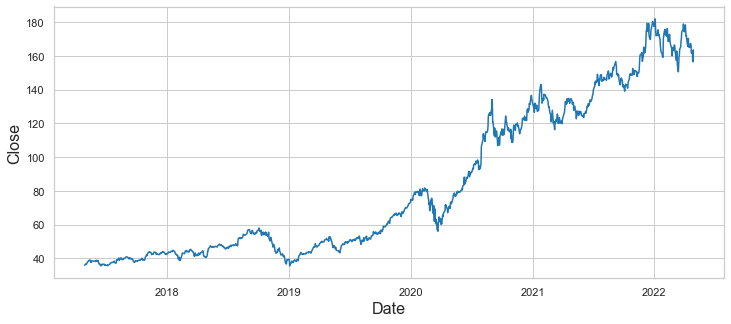

In [6]:
plt.figure(figsize=[12., 5.])
ax = sns.lineplot(df.index, df.Close, data=df)
#ax.set_xlabel('months');

In [7]:
# Select time frame
# df = df[df['Date'] >= '2022-01-01']

# Create y variable
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

# Select features 
selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']

reduced_df = df[selected_features + basic_features]



In [8]:
tscv = TimeSeriesSplit(n_splits=5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [9]:
def convert_df(df):
    '''
    Converts the dataframe to the appropriate types.
    '''
    # Convert data to float32 for PyTorch
    df = df.astype(np.float32)

    # I'm going to convert this to train and test instead of train and valid.
    # Train will include validation set through cross validation.

    # Split training and validation data
    split = int(0.8 * len(df))
    x_train = df[:split].to_numpy() #.reshape(-1, 1)
    x_test = df[split:].to_numpy() #.reshape(-1, 1)

    y_train = y[:split].reshape(-1, 1)
    y_test = y[split:].reshape(-1, 1)

    # scale data: MOVED THIS TO HAPPEN WITHIN CROSS VALIDATION

    # t_scaler = MinMaxScaler(feature_range=(-1, 1))
    # v_scaler = MinMaxScaler(feature_range=(-1, 1))
    # x_train = t_scaler.fit_transform(x_train)
    # x_test = v_scaler.fit_transform(x_test)

    # convert training data to tensor
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_test = torch.tensor(x_test, dtype=torch.float32)

    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    return x_train, y_train, x_test, y_test

In [10]:
# Create training and validation set:
x_train, y_train, x_test, y_test = convert_df(reduced_df)
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [11]:
def get_batches(data, window):
    """
    Takes data with shape (n_samples, n_features) and creates mini-batches
    with shape (1, window). 
    """
    x_data, y_data = data
    L = len(x_data)
    for i in range(L - window):
        x_sequence = x_data[i:i + window]
        y_sequence = y_data[i:i + window]
        yield x_sequence, y_sequence

In [12]:
class stocksLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_p):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        self.fc   = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
   
        out, hs = self.lstm(x, hs)           # out.shape = (batch_size, seq_len, hidden_size)
        out = out.view(-1, self.hidden_size) # out.shape = (seq_len, hidden_size)     
        out = self.fc(out)
        
        return out, hs

In [13]:
def train(model, epochs, train_set, valid_data=None, lr=0.001, print_every=100):

    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    valid_loss = []
    
    for e in range(epochs):
        
        hs = None
        t_loss = 0
        for x, y in get_batches(train_set, 12):

            opt.zero_grad()
            
            # Create batch_size dimension
            x = x.unsqueeze(0)
            out, hs = model(x, hs)
            hs = tuple([h.data for h in hs])
            
            loss = criterion(out, y)
            loss.backward()
            opt.step()
            t_loss += loss.item()
            
        if valid_data is not None:
                model.eval()
                val_x, val_y = valid_data
                val_x = val_x.unsqueeze(0)
                preds, _ = model(val_x, hs)
                v_loss = criterion(preds, val_y)
                valid_loss.append(v_loss.item())
                
                model.train()
            
        train_loss.append(np.mean(t_loss))
            
        if print_every:    
            if e % print_every == 0:
                print(f'Epoch {e}:\nTraining Loss: {train_loss[-1]}')
                if valid_data is not None:
                    print(f'Validation Loss: {valid_loss[-1]}')
        
    return train_loss, valid_loss
    
#     plt.figure(figsize=[8., 6.])
#     plt.plot(train_loss, label='Training Loss')
#     plt.plot(valid_loss, label='Validation Loss')
#     plt.title('Loss vs Epochs')
#     plt.xlabel('Epochs')
#     plt.legend()
#     plt.show()

In [14]:
def train_cross_valid(model, epochs, lr, training_data):
    train_losses = []
    valid_losses = []
    X_train, y_train = training_data
    for train_index, validation_index in tscv.split(X_train):
        # print("TRAIN:", train_index, "VALIDATION:", validation_index)
        # Split training and validation data
        # split = int(0.8 * len(df))
        # x_train = X_train[train_index].to_numpy() #.reshape(-1, 1)
        # x_valid = X_train[validation_index].to_numpy() #.reshape(-1, 1)
        x_train_fold = X_train[train_index]
        x_valid_fold = X_train[validation_index]

        y_train_fold = y[train_index].reshape(-1, 1)
        y_valid_fold = y[validation_index].reshape(-1, 1)

        # scale data
        # t_scaler = MinMaxScaler(feature_range=(-1, 1))
        # v_scaler = MinMaxScaler(feature_range=(-1, 1))
        t_scaler = MinMaxScaler()
        x_train_fold = t_scaler.fit_transform(x_train_fold)
        x_valid_fold = t_scaler.transform(x_valid_fold)

        # convert training data to tensor
        x_train_fold = torch.tensor(x_train_fold, dtype=torch.float32)
        x_valid_fold = torch.tensor(x_valid_fold, dtype=torch.float32)

        y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32)
        y_valid_fold = torch.tensor(y_valid_fold, dtype=torch.float32)

        # Create training and validation set:
        train_data_fold = (x_train_fold, y_train_fold)
        valid_data_fold = (x_valid_fold, y_valid_fold)
        
        train_loss, valid_loss = train(model, epochs, train_data_fold, valid_data=valid_data_fold, lr=lr, print_every=None)
                #Only append losses from the last epoch
        train_losses.append(train_loss[-1])
        valid_losses.append(valid_loss[-1])

    # Compute average loss of folds             
    train_losses_avg = sum(train_losses) / len(train_losses)   
    valid_losses_avg = sum(valid_losses) / len(valid_losses)  
    return train_losses_avg, valid_losses_avg

In [15]:
# Optuna objective function

def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'hidden_size': trial.suggest_int('hidden_size', 40, 100, 20),
              'num_layers': trial.suggest_int('num_layers', 2, 4),
              'dropout_p': trial.suggest_float('dropout_p', 0.0, 0.2, step=0.1)
              }
    
    input_size = x_train.size()[1]  # 21 in current implementation
    hidden_size = 100
    #num_layers = 1     # tuned by optuna
    output_size = 1

    model = stocksLSTM(input_size, params['hidden_size'], params['num_layers'], output_size, params['dropout_p'])
    
    train_losses_avg, valid_losses_avg = train_cross_valid(model, EPOCHS, params['learning_rate'], train_data)

    return valid_losses_avg

In [16]:
EPOCHS = 100

In [33]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=5)

[I 2022-06-01 08:28:51,062] A new study created in memory with name: no-name-27c314f9-5591-4d79-82fe-d35acb0aeac7
[I 2022-06-01 08:29:46,035] Trial 0 finished with value: 1.2979333400726318 and parameters: {'learning_rate': 0.0007745853210869414, 'hidden_size': 40, 'num_layers': 3, 'dropout_p': 0.1}. Best is trial 0 with value: 1.2979333400726318.
[I 2022-06-01 08:30:57,861] Trial 1 finished with value: 1.1418940901756287 and parameters: {'learning_rate': 0.045260648621089986, 'hidden_size': 40, 'num_layers': 4, 'dropout_p': 0.0}. Best is trial 1 with value: 1.1418940901756287.
[I 2022-06-01 08:31:35,270] Trial 2 finished with value: 1.5682919025421143 and parameters: {'learning_rate': 0.00048734857585282617, 'hidden_size': 40, 'num_layers': 2, 'dropout_p': 0.0}. Best is trial 1 with value: 1.1418940901756287.
[I 2022-06-01 08:32:47,017] Trial 3 finished with value: 1.3177677154541017 and parameters: {'learning_rate': 0.00013268203064741737, 'hidden_size': 40, 'num_layers': 4, 'dropout

In [34]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.045260648621089986
hidden_size: 40
num_layers: 4
dropout_p: 0.0


In [35]:
optuna.visualization.plot_optimization_history(study)

# Other possible visuzlizations
#optuna.visualization.plot_slice(study) 
#optuna.visualization.plot_parallel_coordinate(study)

In [36]:
# THIS IS TO COMPARE HP IMPORTANCE. IMPLEMENT WHEN WE OPTIMIZE MORE THAN 1 HP
optuna.visualization.plot_param_importances(study)


In [81]:
def optimize_hyperparameters(df):
    '''
    Find the optimal hyperparameters given the training data.
    '''
    x_train, y_train, x_test, y_test = convert_df(df)
    train_data = (x_train, y_train)
    test_data = (x_test, y_test)

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=30)

    best_trial = study.best_trial

    lr = best_trial.params.get('learning_rate')
    hs = best_trial.params.get('hidden_size')
    nl = best_trial.params.get('num_layers')
    dp = best_trial.params.get('dropout_p')
    return lr, hs, nl, dp, study

## Obtaining the DataFrames

In this cell, we obtain the four desired DataFrames corresponding to 1.) long-term with all features, 2.) short-term with all features, 3.) short-term with selected features (including StockTwits sentiment), and 4.) short-term with selected features (excluding StockTwits sentiment).

In [54]:
#All parameters, whole time period:
df_all = df
df_all.index=df_all['Date']
df_all = df_all.loc[:, df_all.columns !='Date']
# All parameters, short time period:
df_all_short = df[df['Date'] >= '2022-01-01']
# Add sentiment
df_all_short.index = np.array(range(len(df_all_short)))
# df_sentiment = pd.read_csv('final/Stock_Stalkers/data/AAPL_byday_RoBERTa.csv')
df_sentiment = pd.read_csv('data/AAPL_byday_RoBERTa.csv')
# Drop the first empty column for AAPL
df_sentiment = df_sentiment.iloc[: , 1:]
df_sentiment.date = df_sentiment.date.apply(convert)
df_sentiment.rename(columns={'date':'Date'}, inplace=True)
df_all_short = df_all_short.merge(df_sentiment, how='inner', on='Date').fillna(0)
df_all_short.index=df_all_short['Date']
df_all_short = df_all_short.loc[:, df_all_short.columns !='Date']

# Selected parameters, with sentiment:
# sentiment_params = pd.read_csv('feature_selection_AAPL_Sentiment.csv').feature[:20]
sentiment_params = pd.read_csv('data/feature_selection_AAPL_Sentiment.csv').feature[:20]
df_selected_sentiment = df_all_short[sentiment_params]

# Selected parameters, no sentiment:
# noSentiment_params = pd.read_csv('feature_selection_AAPL_NoSentiment.csv').feature[:20]
noSentiment_params = pd.read_csv('data/feature_selection_AAPL_NoSentiment.csv').feature[:20]
df_selected_noSentiment = df_all_short[noSentiment_params]

In [53]:
# df_all_short.index=df_all_short['Date']
# df_all_short = df_all_short.loc[:, df_all_short.columns !='Date']
df_all_short

,High,Low,Open,Close,Volume,Adj Close,Year,Month,Week,Day,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,bullish,bearish
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,182.880005,177.710007,177.830002,182.009995,104487900.0,181.778397,2022,1,1,3,...,-0.143274,-8.251705,-2.942693,-5.309012,173.552778,2.500415,2.469666,406.815182,0,0
2022-01-04,182.940002,179.119995,182.630005,179.699997,99310400.0,179.471344,2022,1,1,4,...,-0.189433,-6.848703,-3.723895,-3.124807,174.349880,-1.269160,-1.277282,400.382888,0,0
2022-01-05,180.169998,174.639999,179.610001,174.919998,94537600.0,174.697418,2022,1,1,5,...,-0.407488,-6.083336,-4.195783,-1.887553,174.357792,-2.659988,-2.696006,387.072762,545,195
2022-01-06,175.300003,171.639999,172.699997,172.000000,96904000.0,171.781143,2022,1,1,6,...,-0.653812,-5.210295,-4.398686,-0.811609,174.294544,-1.669334,-1.683424,378.941893,548,170
2022-01-07,174.139999,171.029999,172.889999,172.169998,86709100.0,171.950928,2022,1,1,7,...,-0.791825,-5.341759,-4.587300,-0.754458,174.226442,0.098836,0.098787,379.415261,478,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-22,167.869995,161.500000,166.460007,161.789993,84775200.0,161.789993,2022,4,16,22,...,-0.658369,-4.834595,-5.769592,0.934997,170.303486,-2.782120,-2.821555,350.511661,756,510
2022-04-25,163.169998,158.460007,161.119995,162.880005,96046400.0,162.880005,2022,4,17,25,...,-0.666083,-2.708870,-5.157448,2.448578,169.837855,0.673720,0.671461,353.546848,951,395
2022-04-26,162.339996,156.720001,162.250000,156.800003,95623200.0,156.800003,2022,4,17,26,...,-0.870720,-1.087910,-4.343540,3.255630,168.820698,-3.732810,-3.804264,336.616804,921,531


## Study with long-term data and all parameters.

In [78]:
x_train, y_train, x_test, y_test = convert_df(df_all)
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [80]:
lr_lt, hs_lt, nl_lt, dp_lt, study_lt = optimize_hyperparameters(df_all)

In [ ]:
output_size = 1
model_lt = stocksLSTM(x_train_lt.size()[1], hs_lt, nl_lt, output_size, dp_lt)

In [ ]:
train_loss_lt, valid_loss_lt = train(model_lt, epochs, train_data_lt, valid_data=None, lr=nl_lt)

## Study with short-term data and all parameters.

In [82]:
x_train, y_train, x_test, y_test = convert_df(df_all_short)
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [57]:
lr_sta, hs_sta, nl_sta, dp_sta, study_sta = optimize_hyperparameters(df_all_short)

[I 2022-06-01 11:32:35,006] A new study created in memory with name: no-name-237b876b-f7e2-4360-862f-191e4d9129b2
[I 2022-06-01 11:34:54,443] Trial 0 finished with value: 1.5487836599349976 and parameters: {'learning_rate': 0.00016825233139299272, 'hidden_size': 40, 'num_layers': 3, 'dropout_p': 0.0}. Best is trial 0 with value: 1.5487836599349976.
[I 2022-06-01 11:36:41,714] Trial 1 finished with value: 1.4260367274284362 and parameters: {'learning_rate': 0.011430207624875703, 'hidden_size': 40, 'num_layers': 2, 'dropout_p': 0.1}. Best is trial 1 with value: 1.4260367274284362.
[I 2022-06-01 11:39:11,379] Trial 2 finished with value: 1.7322473049163818 and parameters: {'learning_rate': 0.002489045352531816, 'hidden_size': 40, 'num_layers': 3, 'dropout_p': 0.0}. Best is trial 1 with value: 1.4260367274284362.
[I 2022-06-01 11:42:41,637] Trial 3 finished with value: 1.1768341302871703 and parameters: {'learning_rate': 4.402933936266574e-05, 'hidden_size': 100, 'num_layers': 3, 'dropout_

In [ ]:
print("learning rate: " + str(lr_sta))
print("hidden size: " + str(hs_sta))
print("number of layers: " + str(nl_sta))
print("dropout rate: " + str(dp_sta))

In [66]:
output_size = 1
model_sta = stocksLSTM(x_train.size()[1], hs_sta, nl_sta, output_size, dp_sta)

In [68]:
train_loss_sta, valid_loss_sta = train(model_sta, EPOCHS, train_data, valid_data=None, lr=nl_sta, print_every=10)

Epoch 0:
Training Loss: 56415.60331171751
Epoch 10:
Training Loss: 52.49793195724487
Epoch 20:
Training Loss: 61.942117273807526
Epoch 30:
Training Loss: 54.58425962924957
Epoch 40:
Training Loss: 508.137579202652
Epoch 50:
Training Loss: 551.5477592349052
Epoch 60:
Training Loss: 553.9959895014763
Epoch 70:
Training Loss: 573.9077069163322
Epoch 80:
Training Loss: 563.4315785765648
Epoch 90:
Training Loss: 561.8330665230751


In [72]:
# model_sta.eval()
# val_x, val_y = test_data
# val_x = val_x.unsqueeze(0)
# hs = None
# out, hs = model_sta(val_x, hs)
# hs = tuple([h.data for h in hs])
# preds, _ = model_sta(val_x, hs_sta)
# criterion = nn.MSELoss()
# v_loss = criterion(preds, val_y)
# v_loss.item()

TypeError: 'int' object is not subscriptable

## Study with short-term data and selected parameters, including StockTwits sentiment.

In [83]:
x_train, y_train, x_test, y_test = convert_df(df_selected_sentiment)
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [ ]:
lr_sts, hs_sts, nl_sts, dp_sts, study_sts = optimize_hyperparameters(df_selected_sentiment)

[I 2022-06-01 13:11:23,603] A new study created in memory with name: no-name-decbaf25-c369-417d-8ef7-0bf5201efbb2
[I 2022-06-01 13:13:41,104] Trial 0 finished with value: 1.3155088901519776 and parameters: {'learning_rate': 0.0023658738818985027, 'hidden_size': 40, 'num_layers': 3, 'dropout_p': 0.2}. Best is trial 0 with value: 1.3155088901519776.
[I 2022-06-01 13:15:22,436] Trial 1 finished with value: 1.2071531534194946 and parameters: {'learning_rate': 0.00034933036606771034, 'hidden_size': 40, 'num_layers': 2, 'dropout_p': 0.0}. Best is trial 1 with value: 1.2071531534194946.
[I 2022-06-01 13:17:52,169] Trial 2 finished with value: 1.1682140111923218 and parameters: {'learning_rate': 0.00031695586968760313, 'hidden_size': 100, 'num_layers': 2, 'dropout_p': 0.2}. Best is trial 2 with value: 1.1682140111923218.
[I 2022-06-01 13:21:06,949] Trial 3 finished with value: 1.0470303297042847 and parameters: {'learning_rate': 0.05910342647121011, 'hidden_size': 40, 'num_layers': 3, 'dropout

In [ ]:
print("learning rate: " + str(lr_sts))
print("hidden size: " + str(hs_sts))
print("number of layers: " + str(nl_sts))
print("dropout rate: " + str(dp_sts))

In [ ]:
output_size = 1
model_sts = stocksLSTM(x_train.size()[1], hs_sts, nl_sts, output_size, dp_sts)

In [ ]:
train_loss_sts, valid_loss_sts = train(model_sts, epochs, train_data, valid_data=None, lr=nl_sts)

## Study with short-term data and selected parameters, excluding StockTwits sentiment.

In [75]:
x_train, y_train, x_test, y_test = convert_df(df_selected_noSentiment)
train_data = (x_train, y_train)
test_data = (x_test, y_test)

In [76]:
lr_stns, hs_stns, nl_stns, dp_stns, study_stns = optimize_hyperparameters(df_selected_noSentiment)

[I 2022-06-01 12:59:30,708] A new study created in memory with name: no-name-8f2e51d6-ab62-43ba-b250-6d6c574e06dd
[I 2022-06-01 13:01:15,727] Trial 0 finished with value: 1.1007951259613038 and parameters: {'learning_rate': 2.7049066977065758e-05, 'hidden_size': 60, 'num_layers': 2, 'dropout_p': 0.0}. Best is trial 0 with value: 1.1007951259613038.


In [ ]:
output_size = 1
model_stns = stocksLSTM(x_train.size()[1], hs_stns, nl_stns, output_size, dp_stns)

In [ ]:
train_loss_stns, valid_loss_stns = train(model_stns, epochs, train_data, valid_data=None, lr=nl_stns)

***************
CODE IS WORKING UP TO HERE
****


In [ ]:
# train(model, 500, train_data, lr=0.0005, valid_data=valid_data)
train_losses, valid_losses = train_cross_valid(model, 200, 0.0005, train_data)

In [ ]:
# get predictions on training set
hs = None
train_preds, hs = model(x_train.unsqueeze(0), hs)
train_preds = t_scaler.inverse_transform(train_preds.detach())

# Get predictions on validation data
valid_preds, hs = model(x_valid.unsqueeze(0), hs)
valid_preds = v_scaler.inverse_transform(valid_preds.detach())

In [ ]:
valid_preds, hs = model(x_valid.unsqueeze(0), hs)
valid_preds = valid_preds.reshape(-1)
valid_preds = np.where(valid_preds > 0, 1, -1)

y_valid_np = y_valid.numpy().reshape(-1)

correct_preds = np.where(valid_preds == y_valid_np, 1, 0)
valid_acc = sum(correct_preds) / len(correct_preds)
valid_acc



In [ ]:
train_time = data.index[:split]
valid_time = data.index[split:]

In [ ]:
plt.plot(train_time, train_preds.squeeze(), 'r--', label='Training Predictions', )
plt.plot(valid_time, valid_preds.squeeze(), 'g--', label='Validation Predictions')
#plt.plot(reduced_df.index, reduced_df.y.detach().numpy(), label='Actual')
#plt.xticks(np.arange(0,145,12))
plt.legend()